In [1]:
import os
import pandas as pd
import janitor
import numpy as np
pd.set_option('display.max_columns', 100)

import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.05, 
              style='whitegrid', palette='dark') #  Darkgrid Whitegrid Dark White Ticksimport matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from forestplot import forestplot
import matplotlib.ticker as mtick

def save_mpl_fig(savepath):
    plt.savefig(f"{savepath}.pdf", dpi=None, bbox_inches="tight", pad_inches=0)
    plt.savefig(f"{savepath}.png", dpi=120, bbox_inches="tight", pad_inches=0)
    
DATAPATH = "../adult-data/output"        

In [2]:
# (fold cell) Load nad prep web browsing data
# output = df with visits to adult sites
usecols_web_desktop = ["caseid", "category", "private_domain", "visit_duration", "visit_time_local"]
usecols = ["caseid", "category", "private_domain", "page_duration", "session_start_time"]

df = (pd.concat([
        # Get web_mobile
        pd.read_csv(
            os.path.join(DATAPATH, "realityMine_web_mobile_2022-06-01_2022-06-30.csv"),
            usecols=usecols_web_desktop,
            low_memory=False,
        ), 
        # Get web_desktop
        pd.read_csv(
            os.path.join(DATAPATH, "realityMine_web_desktop_2022-06-01_2022-06-30.csv"),
            usecols=usecols_web_desktop,
            low_memory=False,
        ),
        # Get web
        (pd.read_csv(
            os.path.join(DATAPATH, "realityMine_web_2022-06-01_2022-06-30.csv"),
            usecols=usecols,
            low_memory=False,
        )
         # Renaming columns to be consistent w/ web_mobile & web_desktop
         .rename_column("session_start_time", "visit_time_local")
         .rename_column("page_duration", "visit_duration")
        )
        ])
      # Post-merge cleanup
      .query("category.str.contains('adult', case=False, na=False)")
      .dropna(subset=["caseid", "category", "visit_duration"])
     )
print("output = df with visits to adult sites")
print(f"{len(df)=:,}")
df.head()

output = df with visits to adult sites
len(df)=75,776


,caseid,private_domain,category,visit_time_local,visit_duration
6,210362181,xnxx.co,"Adult, Business",2022-06-01 03:50:49,1
7,210362181,xnxx.com,Adult,2022-06-01 03:50:50,522
9,210362181,xnxx.com,Adult,2022-06-01 04:01:59,1335
13,210362181,xnxx.com,Adult,2022-06-01 04:43:16,7150
272,335844793,xnxx.com,Adult,2022-06-01 14:59:55,151


In [3]:
df_adultsites_count = (df
                       .groupby(["private_domain", "category"])
                       .size()
                       .reset_index()
                       .rename_column(0, "count")
                       .sort_values("count", ascending=False, ignore_index=True)
                       # Get total visit duration of websites
                       .merge((df
                               .groupby(["private_domain", "category"])
                               .visit_duration.sum()
                               .reset_index()
                               # Normalize from second(s) to hour(s)
                               .assign(visit_duration=lambda df: df.visit_duration/3600)
                               .round(decimals=0)
                               .assign(visit_duration=lambda df: df.visit_duration.apply(int))
                              ), how="left", on=["private_domain", "category"], validate="1:1"
                             )                       
                       # Preparing for plot
                       .assign(ll=lambda df: df["count"])
                       .assign(hl=lambda df: df["count"])
                       # Format count and visit_duration
                       .assign(count_str=lambda df: df.apply(lambda x: "{:,}".format(x['count']), axis=1))
                       .assign(count_str=lambda df: df.count_str.apply(lambda x: x.rjust(7) if len(x)<7 else x))
                       .assign(visit_duration_str=lambda df: df.apply(lambda x: "{:,}".format(x['visit_duration']), axis=1))
                       .assign(visit_duration_str=lambda df: df.visit_duration_str.apply(lambda x: x.rjust(5) if len(x)<5 else x))
                       .assign(category=lambda df: df.category.apply(lambda x: x.rjust(31) if len(x)<31 else x))
                      )
df_adultsites_count.head(8)

,private_domain,category,count,visit_duration,ll,hl,count_str,visit_duration_str
0,xvideos.com,Adult,7646,165,7646,7646,"7,646",165
1,nifty.org,"Adult, Messageboards and Forums",7456,134,7456,7456,"7,456",134
2,pornhub.com,Adult,5503,162,5503,5503,"5,503",162
3,xnxx.com,Adult,3993,169,3993,3993,"3,993",169
4,chaturbate.com,Adult,3952,65,3952,3952,"3,952",65
5,xhamster.com,Adult,3212,91,3212,3212,"3,212",91
6,onlyfans.com,"Adult, Business",2659,28,2659,2659,"2,659",28
7,myfreecams.com,"Adult, Streaming Media",2143,20,2143,2143,"2,143",20


In [4]:
df.visit_duration.quantile(q=0.1)

1.0

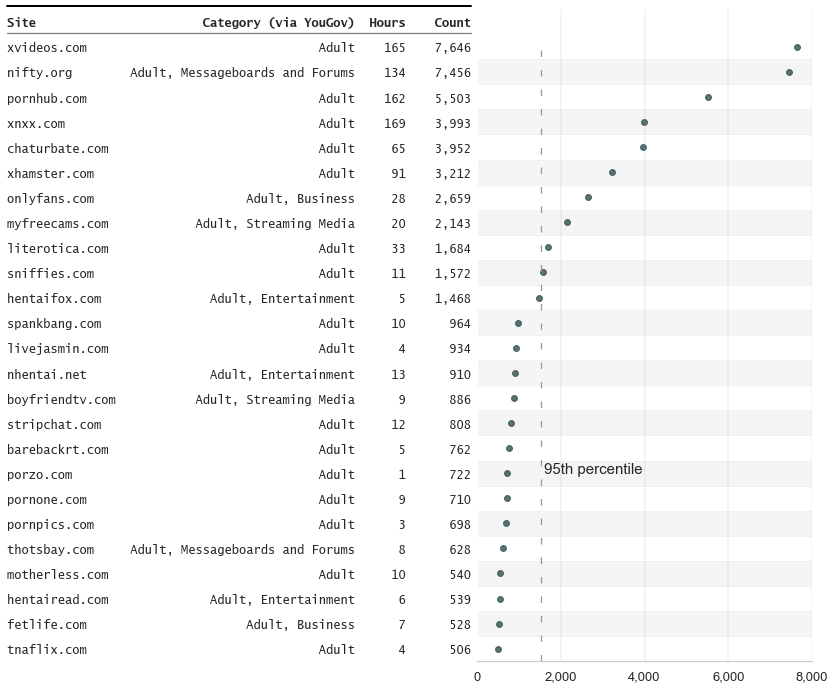

In [5]:
# Plot (fold cell)
ax = forestplot(df_adultsites_count.head(25), 
                estimate="count", 
                ll="ll", hl="hl",
                varlabel="private_domain",
#                 xticks=[0,60_000, 120_000,180_000],
                annote=["category", "visit_duration_str", "count_str"],
                annoteheaders=["          Category (via YouGov)", "Hours", "  Count"],
                ci_report=False,
                figsize=(6,12),
                color_alt_rows=True,
                xticks=range(0,9000,2000),  # x-ticks to be printed
                table=True,
               **{"marker": "o",  # set maker symbol as diamond
                  "variable_header": "Site",
                  "markersize": 35,  # adjust marker size
#                   "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                  "xlinecolor": "1",  # gray color for x-reference line
                  "xtick_size": 13,  # adjust x-ticker fontsize
                 }   
               )
ax.xaxis.set_ticks_position('none') 
ax.grid(False)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
ax.set_ylim(-.5, 25.5) # Gets rid of white padding above
for vline in [2000, 4000, 6000, 8000]:
    ax.vlines(vline, ymin=-.5, ymax=29.6, colors=".6", linewidth=.2)
annotation = "95th percentile"
plt.annotate(annotation, (df_adultsites_count["count"].quantile(q=.99)*1.05, 7), size=15)
plt.axvline(
    df_adultsites_count["count"].quantile(q=.99), 
    ymax=.95, 
    color=".6", 
    ls=(0, (5, 10)), 
    lw=1.3
)
save_mpl_fig(os.path.join("../figs/top_25_adultsites"))

In [6]:
df_zero_duration = (df
                    .query(f"visit_duration==0")
                    .groupby(["private_domain", "category"])
                    .size()
                    .reset_index()
                    .rename_column(0, "count")
                    .sort_values("count", ascending=False, ignore_index=True)
                   )
df_zero_duration.head(20)

,private_domain,category,count
0,nifty.org,"Adult, Messageboards and Forums",1700
1,xvideos.com,Adult,418
2,hentaifox.com,"Adult, Entertainment",331
3,pornpics.com,Adult,178
4,sniffies.com,Adult,166
5,pornhub.com,Adult,158
6,literotica.com,Adult,154
7,myfreecams.com,"Adult, Streaming Media",128
8,boyfriendtv.com,"Adult, Streaming Media",123
9,xnxx.com,Adult,72
